<a href="https://colab.research.google.com/github/Faizi-AdnanFahad/Intro_to_machine_Learning_EECS2001/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying to Understand Machine Learning for Regression


In [ ]:
# import all that is needed 
import keras
from random import random 
import matplotlib.pyplot as plt
import numpy as np
from keras import models, layers
import math
from tensorflow.keras.utils import to_categorical

In [ ]:
##########################################################
# setAP(APValues)                                        #
#   AP are "Attempt Parameters" (a global variable)      #
#   APValues specifies a list of parameters to set       #
#    eg AP = setAP(["function","exp"],["degree",3])      #
#         sets function = "exp" and degree = 3           #
#         remaining parameters are set to their defaults #
##########################################################
AP = {}    # Make "Attempt Parameters" a global variable 

def setAP(*APV):
  global AP 
  #     parameter name : default value
  AP = {"nDimensions":2,      # x = [x1,..,xn]
        "maxX":100,           # xi in [0..maxX]   
        "categorize":[],      # [] means the output is one real number
                              # [10,20,30] means 4 categories y=
                              # 0 if {yy<10}, 1 if {10<=yy<20}, ..., 3 if {30<=yy} 
        "nItemsTrain":4,  # num of training data
        "nItemsTest": 10000,  # num of testing data
        "function":"poly",    # vs "exp"
        "degree":2,           # x0^degree vs degree^x0
        "graph_r":0,          # graph wrt xr                              ???? what is this?
        "graph_x":[0,1],      # graph with other values set as x
        "logscale":False,     # if True, graph log(y)
        "noise":0,            # add noise to x and y
        "nLayers":2,          # num of layers in the neural network
        "nHidden":512,        # num of nodes in each hidden layer
        "activation":"relu",  # how each neuron is activated
        "epochs":5,           # number of passes through data
        "batch":128,          # num items per hill climbing step
        # not parmeters, as much as global variables 
        "trainX":0, "trainY":0, "testX":0, "testY":0, "network":0}

  for APv in APV:
    AP[APv[0]] = APv[1]

setAP()
print(AP)
setAP(["function","exp"],["degree",3])
print(AP)
print(AP["nDimensions"])
print(AP["function"])
if AP["function"]=="exp":
  print("exellent")

{'nDimensions': 2, 'maxX': 100, 'categorize': [], 'nItemsTrain': 4, 'nItemsTest': 10000, 'function': 'poly', 'degree': 2, 'graph_r': 0, 'graph_x': [0, 1], 'logscale': False, 'noise': 0, 'nLayers': 2, 'nHidden': 512, 'activation': 'relu', 'epochs': 5, 'batch': 128, 'trainX': 0, 'trainY': 0, 'testX': 0, 'testY': 0, 'network': 0}
{'nDimensions': 2, 'maxX': 100, 'categorize': [], 'nItemsTrain': 4, 'nItemsTest': 10000, 'function': 'exp', 'degree': 3, 'graph_r': 0, 'graph_x': [0, 1], 'logscale': False, 'noise': 0, 'nLayers': 2, 'nHidden': 512, 'activation': 'relu', 'epochs': 5, 'batch': 128, 'trainX': 0, 'trainY': 0, 'testX': 0, 'testY': 0, 'network': 0}
2
exp
exellent


In [ ]:
##########################################################
# ff(x) is the precategory function y=f(x) to be learned #
#   AP["function"] specifies which function to use       #
#   AP["nDimensions"] = 2 ie x = [x1,..,xn]              #
#   AP["degree"] = 2 ie degree of poly or base of exp    #
##########################################################
 
def ff(x):
  if AP["function"]=="poly":
    y = 1
    for i in range(AP["nDimensions"]):
      y *= x[i]**AP["degree"] 
    return y

  if AP["function"]=="exp":
    y = 1
    for i in range(AP["nDimensions"]):
      y *= AP["degree"]**x[i] 
    return y

setAP()
print(ff([2,3]))
setAP(["function","exp"])
print(ff([2,3]))

36
32


In [ ]:
###########################################################
# Categorize:                                             #
#   [] means the output is one real number                #
#     f(x) is the function y=f(x) that is to be learned   #
#   [10,20,30] means 4 categories y=                      #
#     0 if {yy<10}, 1 if {10<=yy<20}, ..., 3 if {30<=yy}  #
###########################################################

##########################################################
# y = categoriesY(yy)                                    #
##########################################################

def categoriesY(yy):
  y = 0
  for c in AP["categorize"]:
    if yy>=c: y += 1
  return y

setAP(["categorize",[10,20,30]])
print("Catagories:  9->",categoriesY( 9),
                ", 10->",categoriesY(10),
                ", 19->",categoriesY(19),
                ", 20->",categoriesY(20),
                ", 29->",categoriesY(29),
                ", 30->",categoriesY(30),
                ", 31->",categoriesY(31))

##########################################################
# f(x) is the postcategory function y=f(x) to be learned #
##########################################################

def f(x):
  if AP["categorize"]==[]:
    return ff(x)
  else:
    return categoriesY(ff(x))

setAP()
print("f = ",f([4,4]))
setAP(["categorize",[10,20,30]])
print("f cat = ",f([4,4]))


Catagories:  9-> 0 , 10-> 1 , 19-> 1 , 20-> 2 , 29-> 2 , 30-> 3 , 31-> 3
f =  256
f cat =  3


In [ ]:
###########################################################
# x = randx() is a random x = [x1,..,xn]                  # 
###########################################################
def randx():
  x = np.zeros(AP["nDimensions"]) # ? it definies 2x2 
  for j in range(AP["nDimensions"]):
    x[j] = random()*AP["maxX"] # then how can we set a row 
  return x

print("randx", randx())
 
###########################################################
# randCategories(r):                                      #
#   Generates a random [10,20,30] giving r=4 catagories   #  
#    partitioned using r-1 values of ff(x) for random x   #
###########################################################

def randCategories(r):
  cat = np.zeros(r-1)
  for i in range(r-1):
    cat[i] = ff(randx())
  cat.sort()
  return cat

print("randCategories ", randCategories(4))

randx [89.65100882 62.56511327]
randCategories  [5279488.10112509 7610755.22611404 9640567.14037036]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


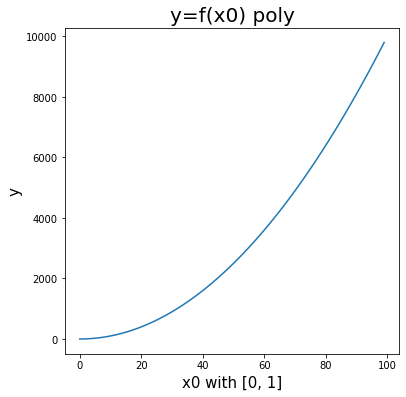

In [ ]:
##############################################################
# Graphs given and learned function                          #
#   AP["graph_r"] = r in range(nDimensions)                  #
#    is such that x_r is horixontal axis of graph            #
#    with 100 values in range(maxX)                          #
#   AP["graph_x"] = x = [x0,x1,...,xn]                       #
#    sets the values of the other variables                  #
#   AP["network"] if one has been learned yet                #
##############################################################
nPoints = 100 # number points in graph

def graph():
  r = AP["graph_r"]
  x = AP["graph_x"]
  network = AP["network"]
  X  = np.zeros((nPoints,AP["nDimensions"]))  # A list of all x=[x0,x1,...,xn] that we want to evaluate
  Xr = np.zeros(nPoints) # A list of all values of xr that we are plotting. This horizontal axes. 
  Yf = np.zeros(nPoints) # A list of the correct y = f(x) values. This verticle axes.
  YL = np.zeros(nPoints) # A list of Learned y values. This second verticle axes.
  for i in range(nPoints):
    X[i] = x
    Xr[i] = (i/nPoints) * AP["maxX"]        
    X[i][r] = Xr[i]
    Yf[i] = f(X[i])
  if network != 0: YL = network.predict(X)
  else:            YL = []
  if AP["logscale"]:
    takeLog(Yf)
    takeLog(YL)
  fig = plt.figure(figsize=(6,6),)
  makeTitles(plt,r,x,network)
  plt.plot(Xr,Yf);
  if network != 0: 
    ax2 = fig.add_subplot();
    ax2.plot(Xr,YL)
  ax0 = fig.add_subplot()  # Plot point [0,0] graph
  ax0.plot([0],[0]);

def makeTitles(plt,r,x,network):
  title = "y=f(x" + str(r) + ") " + AP["function"]
  if AP["logscale"]: title += " logscale"
  if AP["categorize"]!=[]:
    title += " categories"
  if network != 0: title += " and y=Learned(x)"
  plt.title(title, fontsize=20)
  plt.xlabel("x"+str(r)+" with "+ str(x), fontsize=15)
  plt.ylabel("y", fontsize=15)

def takeLog(Y):
  for i in range(len(Y)):
    Y[i] = math.log10( Y[i] )

setAP()
graph() 
# setAP(["graph_x",randx()])
# graph() 
# setAP(["categorize",[25**2,50**2,75**2]])
# graph() 
# setAP(["function","exp"])
# graph() 
# setAP(["function","exp"],["logscale",True])
# graph()

In [ ]:
###########################################################
# buildData:                                              #
#   Stored in AP["trainX"],AP["trainY"]                   #
#   Stored in AP["testX"], AP["testY"]                    #
# x is random with shape (nItemsTrain,nDimensions)        #
# y is computed using y=f(x)                              #
# Number of ___ specified by:                             #
#   AP["nItemsTrain"] = 60000                             #
#   AP["nItemsTest"]  = 10000                             #
#   AP["nDimensions"] = 2   ie x = [x1,..,xn]             #
#   AP["maxX"]        = 100 ie xi = random in [0..maxX]   #
###########################################################

def buildHalf(nItems):
  X = np.zeros((nItems,AP["nDimensions"]))
  Y = np.zeros(nItems)
  for i in range(nItems):
    for j in range(AP["nDimensions"]):
      X[i][j] = random()*AP["maxX"]
    Y[i] = f(X[i])
  return X,Y

X,Y = buildHalf(4)
print(X)
print(Y)

def buildData():
  AP["trainX"],AP["trainY"] = buildHalf(AP["nItemsTrain"])
  AP["testX"], AP["testY"]   = buildHalf(AP["nItemsTest"])
 
setAP()
buildData()
print(AP["trainX"].shape,AP["trainY"].shape)
print(AP["testX"].shape, AP["testY"].shape)

[[ 3.98744812 93.92341463]
 [21.8271179  29.80482291]
 [ 0.94733936 69.36209678]
 [44.76770126 58.78643133]]
[1.40261293e+05 4.23219705e+05 4.31773105e+03 6.92602067e+06]
(4, 2) (4,)
(10000, 2) (10000,)


In [ ]:
###########################################################
# AddNoise(trainX,trainY) adds noise to (trainX,trainY)   #
#    Added noise = random in [-noise/2,+noise/2]          #
#    Note the value of Y is computed                      #
#     from the noiseless version of X                     # 
#    (Let's not add noise to our test data)               #
###########################################################

def AddNoiseX(X,noise):
  for i in range(len(X)):
    for j in range(len(X[i])):
      X[i][j] += (random()-0.5) * noise

def AddNoiseY(Y,noise):
  print("In Y = ", Y)
  for i in range(len(Y)):
     Y[i] += (random()-0.5) * noise

def AddNoise():
  print(AP["trainX"])
  print("Going in ", AP["trainY"])
  AddNoiseX(AP["trainX"],AP["noise"])
  print("Going in ", AP["trainY"])
  AddNoiseY(AP["trainY"],AP["noise"])

X = np.array([[30.0,40.0],[50.0,60.0]])
Y = np.array([30.0,40.0])
AddNoiseX(X,1)
AddNoiseY(Y,1)
print(X)
print(Y)

In Y =  [30. 40.]
[[29.55395121 40.44231833]
 [49.90291004 60.06235421]]
[30.07878121 40.05231605]


In [ ]:
#################################################################
# Learn(trainX,trainY) fits the neural network                  #
#   Categorical or Regression ie one output                     #
#   Number of ___ specified by:                                 #
#     AP["nLayers"] = 2 is num of layers in the neural network  #
#     AP["nHidden"] = 512 is num of passes through data         # 
#     AP["activation"] = 'relu' is how each neuron is activated #
#     AP["epochs"]  = 5   is num of passes through data         #
#     AP["batch"]   = 128 is num items per hill climbing step   #
#################################################################

def learn():
  if AP["categorize"]!=[]: 
    # learned output is a vector of probabilities
    trainYCat = to_categorical(AP["trainY"])  # turn into vector of probabilities.
    testYCat  = to_categorical(AP["testY"])
  else: 
   # learned output is simpy y
    trainYCat = AP["trainY"]                
    testYCat  = AP["testY"]
  
  network = models.Sequential()
  network.add(layers.Dense(AP["nHidden"], 
                           activation=AP["activation"], 
                           input_shape=(AP["nDimensions"],)))
  for i in range(AP["nLayers"]-2):  # For default nLayers, nothing happens here
    network.add(layers.Dense(AP["nHidden"], activation=AP["activation"]))

  if AP["categorize"]!=[]:
    # softmax and crossentropy are good for "probabilities"
    network.add(layers.Dense(len(AP["categorize"])+1, activation='softmax'))
    network.compile(optimizer='rmsprop', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  else: 
    # we just left top layer activation blank, i.e. simply z = weighted sum 
    # expect "accuracy" to be bad because none of the real answers will be perfect.
    # I got optimizer='adam' from googling regression. This was my bug.
    network.add(layers.Dense(1))
    network.compile(optimizer='rmsprop', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    
  network.fit(AP["trainX"],trainYCat, 
              epochs=AP["epochs"], batch_size=AP["batch"], 
              verbose=0) # suppress some of the output
  test_loss, test_acc = network.evaluate(AP["testX"],testYCat)
  AP["network"] = network
  return test_loss 

In [ ]:
#########################################################
# all(APValues) does all for specified value of AP      #
#   APV specifies a list of Attempt Parameters to set   #
#    eg all(["function","exp"],["degree",3])            #
#   returns the test_loss                               #
#########################################################

def all(*APV):
  setAP(*APV)
  buildData()
  AddNoise()
  test_loss = learn(trainX,trainY,testX,testY)
  graph()
  return test_loss 

test_loss = all(["categorize",[25**2,50**2,75**2]])


setAP()
graph() 
setAP(["graph_x",randx()])
graph() 
setAP(["categorize",[25**2,50**2,75**2]])
graph() 
setAP(["function","exp"])
graph() 
setAP(["function","exp"],["logscale",True])
graph()

[[53.25291351 35.23817563]
 [20.85109761 16.27392381]
 [98.46041338 19.35355728]
 [83.33807783 92.17144095]]
Going in  [3. 3. 3. 3.]
Going in  [3. 3. 3. 3.]
In Y =  [3. 3. 3. 3.]


NameError: ignored

In [ ]:
#########################################################
# Plotting AP vs test_loss                              #
#   APParameter: which parameter to vary, eg "degree"   #
#   APRange: values to try, eg [2,3,5,10]               #
#   APV: other parameters to fix to non-default values  #
#    (["function","exp"],["degree",3]])                 #
#########################################################

def plotAP(APParameter,APRange,APV=()):
  Test_loss = np.zeros(len(APRange))   # APRange is our horizonal axis and Test_loss our vertical
  for i in range(len(APRange)):
    APNew = [APParameter,APRange[i]]
    #print("AP = ", APNew)
    print(APNew,*APV)
    setAP(APNew,*APV)
    print("test2: ", AP)
    Test_loss[i] = i
    #network,test_loss = all(APNew,APV)
    #Test_loss[i] = test_loss
  print(APRange,Test_loss,)

  plt.figure(figsize=(6,6))
  plt.plot(APRange,Test_loss);
  plt.xlabel('Degree of x0', fontsize=15)
  plt.ylabel('Test Loss', fontsize=15)
  plt.title('Different Degrees', fontsize=20);

plotAP("degree",[2,3,5,10])
plotAP("degree",[2,3,5,10],(["function","exp"],["maxX",5]))